## <p style="text-align:center; font-family: Arial, sans serif;color:black;">Segmentation Using Neural Networks</p>

## Data Preprocessing

### Extracting the tar.gz file

In [1]:
import tarfile
import os

path = r'C:\Users\deepa\OneDrive\Desktop\panoptic'

In [2]:
os.chdir(path)
fname = os.listdir(".")[2]
print(fname)

idd-segmentation.tar.gz


In [3]:
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname,"r:")
    tar.extractall()
    tar.close()

### Data Preparation

#### Made temperory directory to store all the images and repected fine file

In [5]:
import shutil
new_datasetPath = 'Anue_dataset/'

fine_labels = 'gtFine'  # Annotated images
leftImgsDir = 'leftImg8bit' # Png Images
modes = ['train','val'] # Images

data_dirs = ['IDD_Segmentation'] # main Folder 
tmpAll_dir = 'Anue_dataset/tmpAll' # temperoary Directory

#os.mkdir(tmpAll_dir) #Added

#### The images and annoted files are being placed in one folder and sorted

In [6]:
img_anno_arr = [] # array for annotated images

for data_dir in data_dirs:
    fine_label_path = os.path.join(data_dir,fine_labels)
    leftImgPath = os.path.join(data_dir,leftImgsDir)
    
    for mode in modes:
        fine_label_path_mode = os.path.join(fine_label_path,mode)
        leftImgPath_mode = os.path.join(leftImgPath,mode)
        all_labels_dir = sorted(os.listdir(fine_label_path_mode))
        all_imgs_dir = sorted(os.listdir(leftImgPath_mode))
        
        common_dirs = sorted(list(set(all_labels_dir).intersection(all_imgs_dir)))
        
        for com_dir in common_dirs:
            all_fine_labels_path = os.path.join(fine_label_path_mode,com_dir)
            all_imgs_path = os.path.join(leftImgPath_mode,com_dir)
            #print(com_dir)
            annots = os.listdir(all_fine_labels_path)
            imgss = os.listdir(all_imgs_path)
            
            img_arr = [img_name[:img_name.find('_')] for img_name in imgss]
            
            for anno in annots:
                if anno[:anno.find('_')] in img_arr:
                    img_anno_arr.append(anno[:anno.find('_')])
                    
                    whole_anno_path = os.path.join(all_fine_labels_path,anno)
                    #print(whole_anno_path)
                    whole_img_name = str(anno[:anno.find('_')])+str('_leftImg8bit.png')
                    whole_img_path = os.path.join(all_imgs_path,whole_img_name)
                    #print(whole_img_path)
                    #shutil.copy(whole_anno_path,tmpAll_dir)
                    #shutil.copy(whole_img_path,tmpAll_dir)

In [7]:
p = sorted(os.listdir(tmpAll_dir))
#print(p)

In [8]:
import numpy as np

pk = [int(name[:name.find('_')]) for name in p]
pk = np.unique(pk)

In [9]:
kk = sorted(np.unique(np.array(img_anno_arr).astype(int)))
pk[pk==kk]=1
sum(pk)

7859

#### Split the images and annoted files as train test val

#### Trian and val - 80%
#### Test - 20%

In [10]:
new_modes = ['train','val','test']
np.random.shuffle(img_anno_arr)
test_split_idx = int(0.8*len(img_anno_arr))

trainval_elemts = img_anno_arr[:test_split_idx]

test_elemts = img_anno_arr[test_split_idx:]  # Test

val_split_idx = int(0.8*len(trainval_elemts))

train_elemts = trainval_elemts[:val_split_idx]  # Train

val_elemts = trainval_elemts[val_split_idx:]  # Val

#print(len(train_elemts),len(val_elemts),len(test_elemts))


#### New Dataset for the process 

In [11]:
new_datasetPath = 'new_dataset'

#Moving files seperated into train, val, test - in a different folder called new_dataset
dset = [train_elemts,val_elemts,test_elemts]

for idx,mode in enumerate(new_modes):# 0,train; 1,val; 2,test 
    new_fine_label_path = os.path.join(new_datasetPath,fine_labels,mode)
    new_leftImg_path = os.path.join(new_datasetPath,leftImgsDir,mode)
    
    for elemt in dset[idx]:
        new_label = str(elemt)+str('_gtFine_polygons.json')
        new_img = str(elemt)+str('_leftImg8bit.png')
        new_lab_path = os.path.join(new_fine_label_path,new_label)
        new_img_path = os.path.join(new_leftImg_path,new_img)
        
        #shutil.copy(os.path.join(tmpAll_dir,new_label),new_lab_path)
        #shutil.copy(os.path.join(tmpAll_dir, new_img), new_leftImg_path)

In [12]:
import json

In [13]:
with open('label_to_color_map.txt') as f:
    label_to_color_map = json.load(f)
#label_to_color_map has the label with a color in rgb format:
#"tunnel": [150,120, 90], "non-drivable fallback": [156, 60, 200], "motorcycle": [0,0,230],......
#print(label_to_color_map)

label_arr = np.arange(len(label_to_color_map.keys())) #label 
color_arr = label_to_color_map.values() # color

id_to_label_map = {}
label_to_id_map = {}
color_to_id_map = {}

for i,class_id in enumerate(label_arr):
    label = list(label_to_color_map.keys())[i]
    color = list(label_to_color_map.values())[i]
    
    id_to_label_map[str(class_id)] = label
    label_to_id_map[label] = str(class_id)
    #color_to_id_map[color] = str(class_id)
    

In [14]:
#print(id_to_label_map)
#print(label_to_id_map)

#### Making a copy in text format

In [74]:
with open('class_id_to_label_map.txt','w+') as ff:
    ff.write(json.dumps(id_to_label_map))

with open('label_to_id_map.txt','w+') as fff:
    fff.write(json.dumps(label_to_id_map))

#### Fill the polygon using the respective colors

In [15]:
import cv2
prev_data_path = 'new_dataset'
new_data_path = 'labelled_Anue_dataset'
lab_path = 'gtFine'
im_path = 'leftImg8bit'                     #(This folder was copied to new_data_path as it is)
modes = ['train','test','val']

for mode in modes:
    old_imgs_path = os.path.join(prev_data_path,im_path,mode) #### path where the images are stored in train/val/test data
    ###new_dataset/leftImg8bit/train/.....
    old_anno_path = os.path.join(prev_data_path,lab_path,mode)
    ####### path where annotated images are stored
    #new_dataset/GTFine/train/
    imgs = os.listdir(old_imgs_path) ### making a directory to images path
    for img_ in imgs:
        anno_file_name = str(img_[:img_.find('_')])+str('_gtFine_polygons.json')
        # get annotated file 000030_leftImg8bit.png replaced as 000030__gtFine_polygons.json
        anno_file = os.path.join(old_anno_path,anno_file_name)
        # created a path to annotated file  000030__gtFine_polygons.json
        with open(anno_file) as ff:
            #open  000030__gtFine_polygons.json
            data = json.load(ff)
            
            #load contents of 000030__gtFine_polygons.json into data
            cur_img = cv2.imread(os.path.join(old_imgs_path,img_),cv2.IMREAD_UNCHANGED)
            #Read the following image in cur_img 000030_leftImg8bit.json
            for i, obj in enumerate(data['objects']):
                obj_label = obj['label']
                # sky,wall,road.....
                #try:
                color_tuple = tuple(label_to_color_map[obj_label])
                #except KeyError:
                    #pass
                cv2.fillPoly(cur_img,[np.array(obj['polygon']).astype(np.int32)],color=color_tuple)
                #fill the polygon coordinates with the respective color
            #save_path_img = os.path.join(new_data_path,im_path,mode,img_)
            #cv2.imwrite(save_path_img, cur_img)

## Libraries

In [275]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip,GridDistortion,OpticalDistortion,ChannelShuffle,CoarseDropout,CenterCrop,Crop,Rotate

In [294]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


## Data Preprocessig using Data augmentation

### Train and Test split

In [81]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
#Loading images and masks
def load_data(path,split=0.1):
    X = sorted(glob(os.path.join(path,"images","*.png")))
    Y = sorted(glob(os.path.join(path,"mask","*.png")))
    
    
    # Splitting data into train and testing
    split_size = int(len(X)*split)
    
    train_x,test_x = train_test_split(X,test_size = split_size,random_state=42)
    train_y,test_y = train_test_split(Y,test_size = split_size,random_state=42)

    return(train_x,train_y),(test_x,test_y)   

#Augmentation
def augment_data(images,mask,save_path,augment = True):
    H = 128
    W = 128
    
    for x,y in tqdm(zip(images,mask),total=len(images)):
        #Extract the name
        name = x.split("\\")[-1].split(".")[0]
        
        #Read image and mask
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)
        
        #Augmentation
        if augment == True:
            #Horizontal Flip
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x,mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]
            #GrayScale
            x2 = cv2.cvtColor(x,cv2.COLOR_RGB2GRAY)
            y2 = y
            
            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = CoarseDropout(p=1, min_holes=3, max_holes=10, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented["image"]
            y5 = augmented["mask"]
            
            X = [x,x1,x2,x3,x4,x5]
            Y = [y,y1,y2,y3,y4,y5]
            
        else:
            X = [x]
            Y = [y]
            
            
        index = 0     
        for i , m in zip(X,Y):
            try:
                #Center Cropping
                aug = CenterCrop(H,W,p=1.0)
                augmented  =aug(image = i,mask=m)
                i = augmented["image"]
                m = augmented["mask"]
                
            except Exception as e:
                i = cv2.resize(i,(W,H))
                m = cv2.resize(m,(W,H))
        
            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"
        
            #image_path = os.path.join(save_path,"P:/Panoptic_Segmentation/new_data/train/image",tmp_image_name)
            #mask_path = os.path.join(save_path,"P:/Panoptic_Segmentation/new_data/train/mask",tmp_mask_name)
            
            image_path = os.path.join(save_path,"P:/Panoptic_Segmentation/new_data/test/image",tmp_image_name)
            mask_path = os.path.join(save_path,"P:/Panoptic_Segmentation/new_data/test/mask",tmp_mask_name)
            
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)
            
            index += 1
    
if __name__ == "__main__":
    #seeding
    np.random.seed(42)

    #Load the dataset
    data_path = "P:\Panoptic_Segmentation"
    ( train_x,train_y),(test_x,test_y) = load_data(data_path) 
    
    print(f"Train:\t{len(train_x)} - {len(train_y)}")
    print(f"Test:\t{len(test_x)} - {len(test_y)}")
 
    
    # create Directories to save the augmented data
    create_dir("P:/Panoptic_Segmentation/new_data/train/image/")
    create_dir("P:/Panoptic_Segmentation/new_data/train/mask/")
    create_dir("P:/Panoptic_Segmentation/new_data/test/image/")
    create_dir("P:/Panoptic_Segmentation/new_data/test/mask/")
    
    #Data Augmentation
    #augment_data(train_x,train_y,"P:/Panoptic_Segmentation/new_data/train/",augment = True)
    #augment_data(test_x, test_y, "P://Panoptic_Segmentation\new_data\test",augment = True)
    

  0%|▏                                                                                 | 2/785 [00:00<00:42, 18.41it/s]

Train:	7074 - 7074
Test:	785 - 785


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [00:45<00:00, 17.18it/s]


In [2]:
from glob import glob

In [4]:
image_paths_train = glob("P:/Panoptic_Segmentation/new_data/train/image/*_leftImg8bit_0.png")

In [5]:
label_paths_train = glob("P:/Panoptic_Segmentation/new_data/train/mask/*_leftImg8bit_0.png")

In [6]:
image_paths_train[1:5]

['P:/Panoptic_Segmentation/new_data/train/image\\000065_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/image\\000128_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/image\\000175_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/image\\000179_leftImg8bit_0.png']

In [7]:
label_paths_train[1:5]

['P:/Panoptic_Segmentation/new_data/train/mask\\000065_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/mask\\000128_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/mask\\000175_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/train/mask\\000179_leftImg8bit_0.png']

In [8]:
image_paths_test = glob("P:/Panoptic_Segmentation/new_data/test/image/*_leftImg8bit_0.png")

In [9]:
label_paths_test = glob("P:/Panoptic_Segmentation/new_data/test/mask/*_leftImg8bit_0.png")

In [10]:
image_paths_test[1:5]

['P:/Panoptic_Segmentation/new_data/test/image\\000434_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/image\\000490_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/image\\000590_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/image\\000616_leftImg8bit_0.png']

In [11]:
label_paths_test[1:5]

['P:/Panoptic_Segmentation/new_data/test/mask\\000434_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/mask\\000490_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/mask\\000590_leftImg8bit_0.png',
 'P:/Panoptic_Segmentation/new_data/test/mask\\000616_leftImg8bit_0.png']

In [12]:
print("Length of train images : ",len(label_paths_train))
print("Length of train Segmenatation images : ",len(image_paths_train))
print("Length of test images : ",len(label_paths_test))
print("Length of test Segmenatation images : ",len(image_paths_test))

Length of train images :  7074
Length of train Segmenatation images :  7074
Length of test images :  785
Length of test Segmenatation images :  785


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
from scipy import ndimage

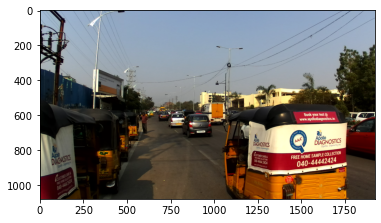

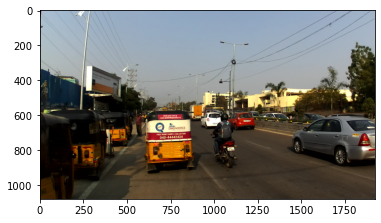

In [32]:
for i in range(2):
    image_frame = imageio.imread(image_paths_train[i])
    
    
    plt.imshow(image_frame)
    plt.show()

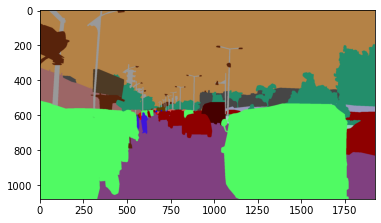

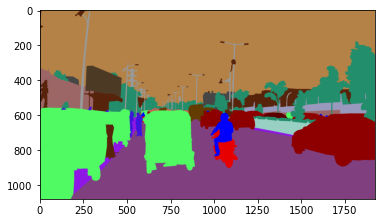

In [33]:
%matplotlib inline
for i in range(2):
    #print(image_paths[i], label_paths[i])
    
    image_frame =imageio.imread(label_paths_train[i])
    
    #get the label images that have the map values encoded in them
   
    plt.imshow(image_frame)
    plt.show()

In [34]:
colors=np.array([
    [150,120,90], #"tunnel": dark khaki
    [156,60,200], #"non-drivable fallback": deep pink
    [0,0,230],    #"motorcycle": blue
    [150,100,100],  #"bridge": sienna
    [250,170,160], #"parking": peach puff
    [244,35,232], #"sidewalk": magenta
    [199,151,187], #"animal": plum
    [107,142,35], #"vegetation": olive drab
    [128,64,128], #"road": purple
    [220,20,60], #"person": crimson
    [37,58,77], #"billboard": slate gray
    [225,130,180], #"fallback background": rose 
    [70,130,180], #"sky": steel blue
    [196,209,152], #"curb": light green
    [70,70,70], #"building": dim gray
    [153,153,153], #"polegroup": gray
    [99,250,80], #"autorickshaw": sea green
    [250,170,30], #"traffic light": goldenrod
    [255,0,0], #"rider": red
    [82,92,214], #"vehicle fallback": blue violet
    [220,220,0], #"traffic sign":  gold
    [0,0,0], #"out of roi": black
    [119,11,32], #"bicycle": maroon
    [0,60,100], #"bus": dark slate gray
    [11,35,88], #"obs-str-bar-fallback": dark blue
    [102,102,156], #"wall": slate blue
    [0,0,90], #"caravan": dark blue
    [153,153,153], #"pole": gray
    [190,153,153], #"fence": light coral
    [229,23,142], #"drivable fallback": deep pink
    [180,165,180], #"guard rail": pink
    [0,0,142], #"car": dark blue
    [0,0,70], #"truck": dark slate gray
    [32,64,128], #"license plate": navy
    [192,192,192], #"rail track": silver
    [89,202,34], #"rectification border": yellow green
    [10,100,200], #"ego vehicle": deep sky blue
    [50,150,250], #"trailer": deep sky blue
    [35,105,70] #"train":  dark slate gray
], dtype=int)

## Semantic segmentation using U-Net Model

## U-Net ARCHITECTURE

![](Proposed-deep-U-net-architecture-for-128128-input-patch-size-Each-gray-box-denotes-a.png)

In [277]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

num_classes = 39

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (128, 128, 3)
    model =build_unet(input_shape,39)
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_112 (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1602 (Conv2D)           (None, 128, 128, 16  448         ['input_112[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_1498 (Batc  (None, 128, 128, 16  64         ['conv2d_1602[0][0]']            
 hNormalization)                )                                                             

## Training U-Net Model

In [279]:
#Parameters
H = 128
W = 128
num_classes = 39


def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

        
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*png")))
    y = sorted(glob(os.path.join(path, "mask", "*png")))
    
    return x, y


def get_colormap(path):
    with open('P:/Panoptic_Segmentation/label_to_color_map.txt') as f:
        label_to_color_map = json.load(f)
        #label_to_color_map has the label with a color in rgb format:
        #"tunnel": [150,120, 90], "non-drivable fallback": [156, 60, 200], "motorcycle": [0,0,230],......
        #print(label_to_color_map)

        label_arr = label_to_color_map.keys() #label 
        color_arr = label_to_color_map.values() # color
        colormap = [[c[0], c[1], c[2]] for c in color_arr]
    
    return list(colormap) , list(label_arr)

def read_image_mask(x, y):
    """ Reading """
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_COLOR)
    assert x.shape == y.shape

    """ Resizing """
    x = cv2.resize(x, (W, H))
    y = cv2.resize(y, (W, H))

    """ Image processing """
    x = x / 255.0
    x = x.astype(np.float32)

    """ Mask processing """
    output = []
    for color in colormap:
        cmap = np.all(np.equal(y, color), axis=-1)
        output.append(cmap)
    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return x, output

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image, mask = read_image_mask(x, y)
        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, num_classes])

    return image, mask

def tf_dataset(x,y,batch = 2):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

if __name__ == "__main__":
    #seeding
    np.random.seed(42)
    tf.random.set_seed(42)
    
    #Directory for storing files
    create_dir("P:/Panoptic_Segmentation/files")
    
    #parameters
    H = 128
    w = 128
    num_classes = 39
    input_shape = (H,W,3)
    
    #Hyperparameters
    batch_size = 2
    lr = 1e-4
    num_epochs = 10
    dataset_path = "P:/Panoptic_Segmentation/new_data"
    
    model_path = os.path.join("P:/Panoptic_Segmentation/files", "model.h5")
    csv_path = os.path.join("P:/Panoptic_Segmentation/files", "data.csv")
    
    #process the colormap
    colormap,classes = get_colormap(dataset_path)
    
    #dataset
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "test")
    
    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)
    
    
    print(f"Train:\t{len(train_x)} - {len(train_y)}")
    print(f"Test:\t{len(valid_x)} - {len(valid_y)}")
    
    
    train_dataset = tf_dataset(train_x,train_y,batch = batch_size)
    valid_dataset = tf_dataset(valid_x,valid_y,batch = batch_size)
    
    model = build_unet (input_shape,num_classes)
    model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(lr), metrics = [dice_coef, iou, Recall(), Precision()])
    #model.summary()
    
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path,append = True),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

    model.fit(train_dataset,epochs = num_epochs,validation_data = valid_dataset,callbacks = callbacks)

Train:	7074 - 7074
Test:	785 - 785
Epoch 1/10
3537/3537 [==============================] - ETA: 0s - loss: 2.5948 - dice_coef: 0.1523 - iou: 0.0847 - recall_27: 0.0626 - precision_27: 0.7056
Epoch 1: val_loss improved from inf to 1.85900, saving model to P:/Panoptic_Segmentation/files\model.h5
3537/3537 [==============================] - 3824s 1s/step - loss: 2.5948 - dice_coef: 0.1523 - iou: 0.0847 - recall_27: 0.0626 - precision_27: 0.7056 - val_loss: 1.8590 - val_dice_coef: 0.3153 - val_iou: 0.1922 - val_recall_27: 0.3168 - val_precision_27: 0.8536 - lr: 1.0000e-04
Epoch 2/10
3537/3537 [==============================] - ETA: 0s - loss: 2.0242 - dice_coef: 0.2916 - iou: 0.1748 - recall_27: 0.2621 - precision_27: 0.7637
Epoch 2: val_loss improved from 1.85900 to 1.74549, saving model to P:/Panoptic_Segmentation/files\model.h5
3537/3537 [==============================] - 3798s 1s/step - loss: 2.0242 - dice_coef: 0.2916 - iou: 0.1748 - recall_27: 0.2621 - precision_27: 0.7637 - val_loss

## Testing

In [329]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score



""" Global parameters """
H = 128
W = 128
num_classes = 39

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*png")))
    y = sorted(glob(os.path.join(path, "mask", "*png")))
    
    return x, y

def grayscale_to_rgb(pred, classes, colormap):
    h, w, _ = pred.shape
    pred = pred.astype(np.int32)
    output = []
    for i, pixel in enumerate(pred.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h, w, 3))
    return output


def save_results(image_x,mask_x,pred,save_image_path):
    h,w, _ = image_x.shape
    line = np.ones((h,10,3))*255
    
    pred = np.expand_dims(pred,axis=-1)
    pred = grayscale_to_rgb(pred,classes,colormap)
    
    cat_images = np.concatenate([image_x,line,mask_x,line,pred],axis= 1)
    cv2.imwrite(save_image_path,cat_images)
    

if __name__ == "__main__":
    #seeding
    np.random.seed(42)
    tf.random.set_seed(42)
    
    #Directory for storing files
    create_dir("P:/Panoptic_Segmentation/results")
    
    #Loading model
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("P:/Panoptic_Segmentation/files/model.h5")    
    #model.summary()
    
    #process the colormap
    colormap,classes = get_colormap(dataset_path)
    
    #dataset
    dataset_path = "P:/Panoptic_Segmentation/new_data"
    valid_path = os.path.join(dataset_path, "test")
    test_x, test_y = load_data(valid_path)
    print(f"Test:\t{len(test_x)} - {len(test_y)}")
    
    #Evaluation and prediction
    SCORE = []
    for x, y in tqdm(zip(test_x,test_y),total=len(test_x)):
        #Extrct the name
        name = x.split("\\")[-1].split(".")[0]
        
        # Reading the image 
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        image_x = image
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        
        #Reading the mask
        mask = cv2.imread(y, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (W, H))
        mask_x = mask
        onehot_mask = []
        for color in colormap:
            cmap = np.all(np.equal(mask, color), axis=-1)
            onehot_mask.append(cmap)
        onehot_mask = np.stack(onehot_mask, axis=-1)
        onehot_mask = np.argmax(onehot_mask, axis=-1)
        onehot_mask = onehot_mask.astype(np.int32)
        
        
        #Prediction
        pred = model.predict(image,verbose = 0)[0]
        pred = np.argmax(pred, axis=-1)
        pred = pred.astype(np.float32)
        
        cv2.imwrite("pred.png",pred*(255/39))
        
        #Save the prediction
        save_image_path = os.path.join("P:/Panoptic_Segmentation/results",f"{name}.png")
        save_results(image_x,mask_x,pred,save_image_path)
    
        
        # Flatten the array """
        onehot_mask = onehot_mask.flatten()
        pred = pred.flatten()
        
        
        labels = [i for i in range(num_classes)]
            
        # Calculating the metrics values
        #acc_value = accuracy_score(onehot_mask, pred )
        f1_value = f1_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
        jac_value = jaccard_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
        recall_value = recall_score(onehot_mask, pred, labels=labels, average=None,zero_division=0)
        precision_value = precision_score(onehot_mask, pred, labels=labels, average=None,zero_division=0)
        
        SCORE.append([f1_value, jac_value,recall_value,precision_value])
        
    
    # Metrics values 
    score = np.array(SCORE)
    score = np.mean(score,axis=0)
    print(score.shape)
    
    f = open("P:/Panoptic_Segmentation/files/score.csv", "w")
    f.write("Class,F1,Jaccard,Recall,Precision\n")
    
    l = ["Class", "F1", "Jaccard", "Recall","Precision"]
    print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s} {l[3]:10s} {l[4]:10s}")
    print("-"*60)
    
    
    for i in range(score.shape[1]):
        class_name = classes[i]
        f1 = score[0, i]
        jac = score[1, i]
        Recall = score[2,i]
        Precision = score[3,i]
        dstr = f"{class_name:15s}: {f1:1.5f}  {jac:1.5f}  {Recall :1.5f}  {Precision : 1.5f}"
        print(dstr)
        f.write(f"{class_name:15s},{f1:1.5f},{jac:1.5f},{Recall :1.5f},{Precision : 1.5f}\n")
     
    print("-"*60)
    class_mean = np.mean(score, axis=-1)
    class_name = "Mean"
    f1 = class_mean[0]
    jac = class_mean[1]
    Recall = class_mean[2]
    Precision = class_mean[3]
    dstr = f"{class_name:15s}: {f1:1.5f}  {jac:1.5f}  {Recall :1.5f}  {Precision : 1.5f}"
    print(dstr)
    f.write(f"{class_name:15s},{f1:1.5f},{jac:1.5f}{Recall :1.5f},{Precision : 1.5f}\n")

    f.close()
    

  0%|                                                                                          | 0/785 [00:00<?, ?it/s]

Test:	785 - 785


100%|████████████████████████████████████████████████████████████████████████████████| 785/785 [03:04<00:00,  4.26it/s]

(4, 39)
Class           F1         Jaccard    Recall     Precision 
------------------------------------------------------------
tunnel         : 0.00000  0.00000  0.00000   0.00000
non-drivable fallback: 0.00000  0.00000  0.00000   0.00000
motorcycle     : 0.08786  0.05775  0.07827   0.16755
bridge         : 0.00000  0.00000  0.00000   0.00000
parking        : 0.00000  0.00000  0.00000   0.00000
sidewalk       : 0.00000  0.00000  0.00000   0.00000
animal         : 0.00000  0.00000  0.00000   0.00000
vegetation     : 0.38606  0.31840  0.45921   0.37568
road           : 0.58894  0.53196  0.65850   0.56808
person         : 0.00000  0.00000  0.00000   0.00000
billboard      : 0.00000  0.00000  0.00000   0.00000
fallback background: 0.00000  0.00000  0.00000   0.00000
sky            : 0.19024  0.16177  0.17699   0.23457
curb           : 0.04906  0.03641  0.04982   0.06778
building       : 0.04480  0.02735  0.04771   0.09368
polegroup      : 0.02924  0.01711  0.02360   0.10370
autorickshaw 

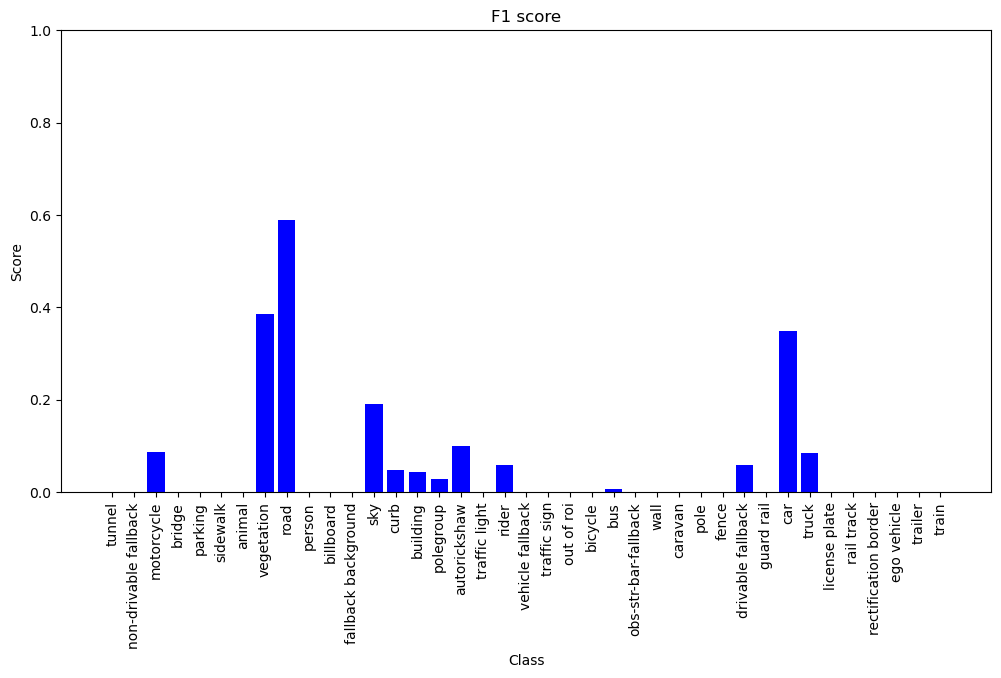

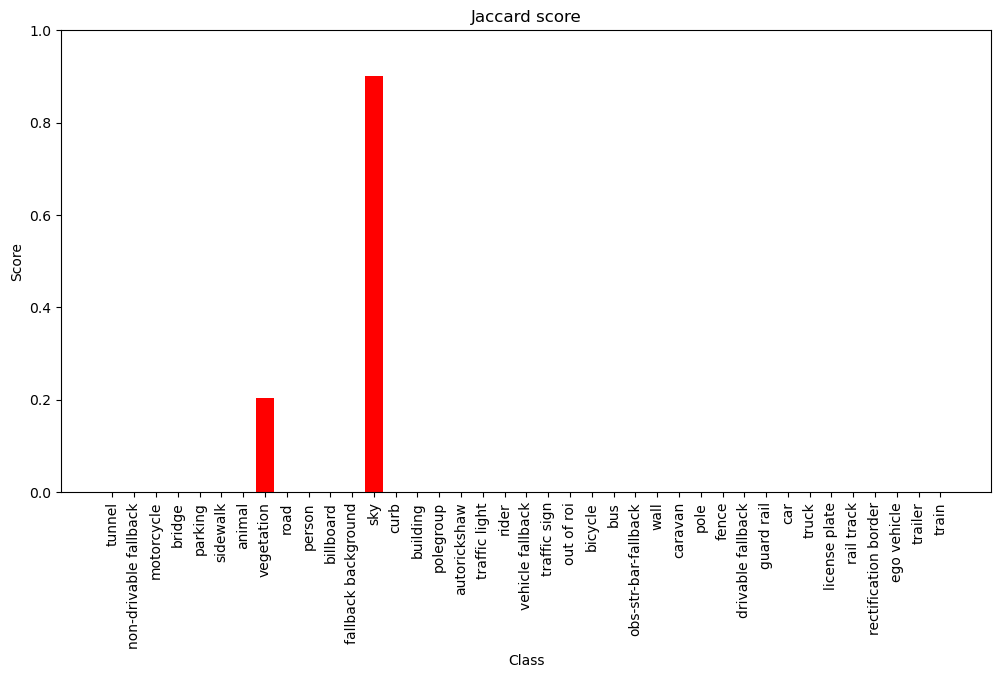

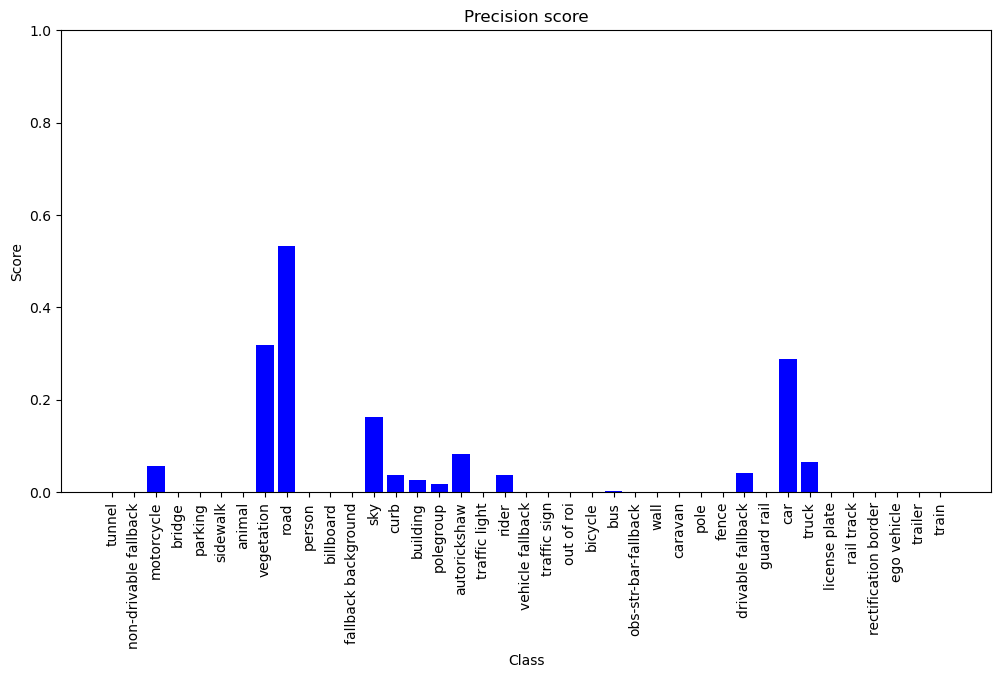

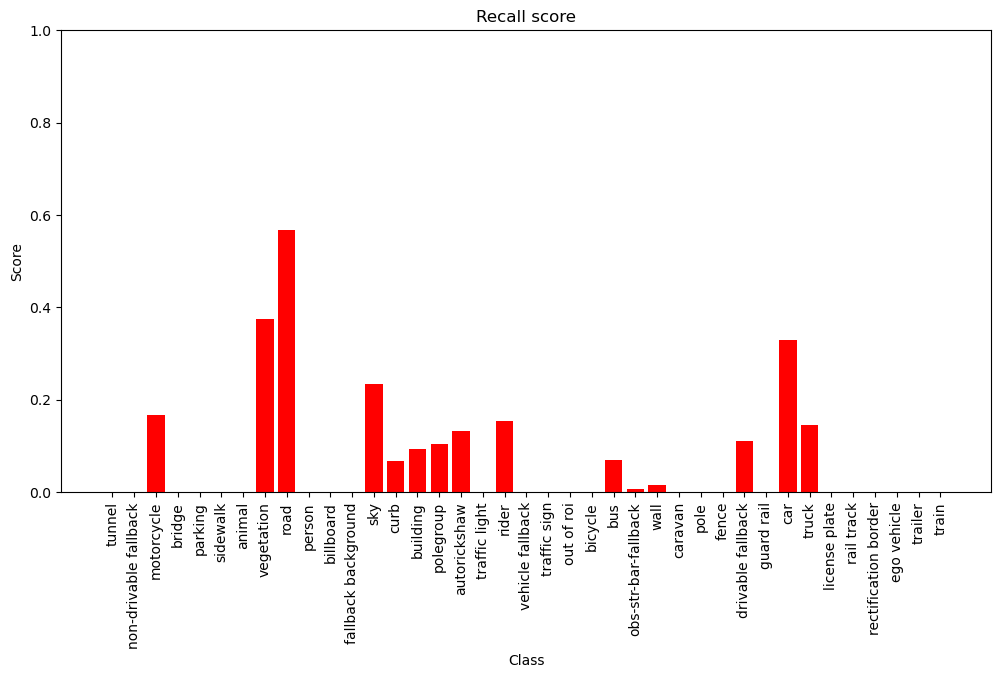

In [89]:
import matplotlib.pyplot as plt

# assuming `score` is a numpy array of shape (2, num_classes)
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

# create a bar chart for F1 scores
plt.figure(figsize=(12,6))
plt.bar(class_names, f1_scores, color='b')
plt.title('F1 score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=90)
plt.show()


# create a bar chart for Jaccard scores
plt.figure(figsize=(12,6))
plt.bar(class_names, jac_value, color='r')
plt.title('Jaccard score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=90)
plt.show()


# create a bar chart for Precision scores
plt.figure(figsize=(12,6))
plt.bar(class_names, precision_scores, color='b')
plt.title('Precision score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=90)
plt.show()


# create a bar chart for Recall scores
plt.figure(figsize=(12,6))
plt.bar(class_names, recall_scores, color='r')
plt.title('Recall score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=90)
plt.show()

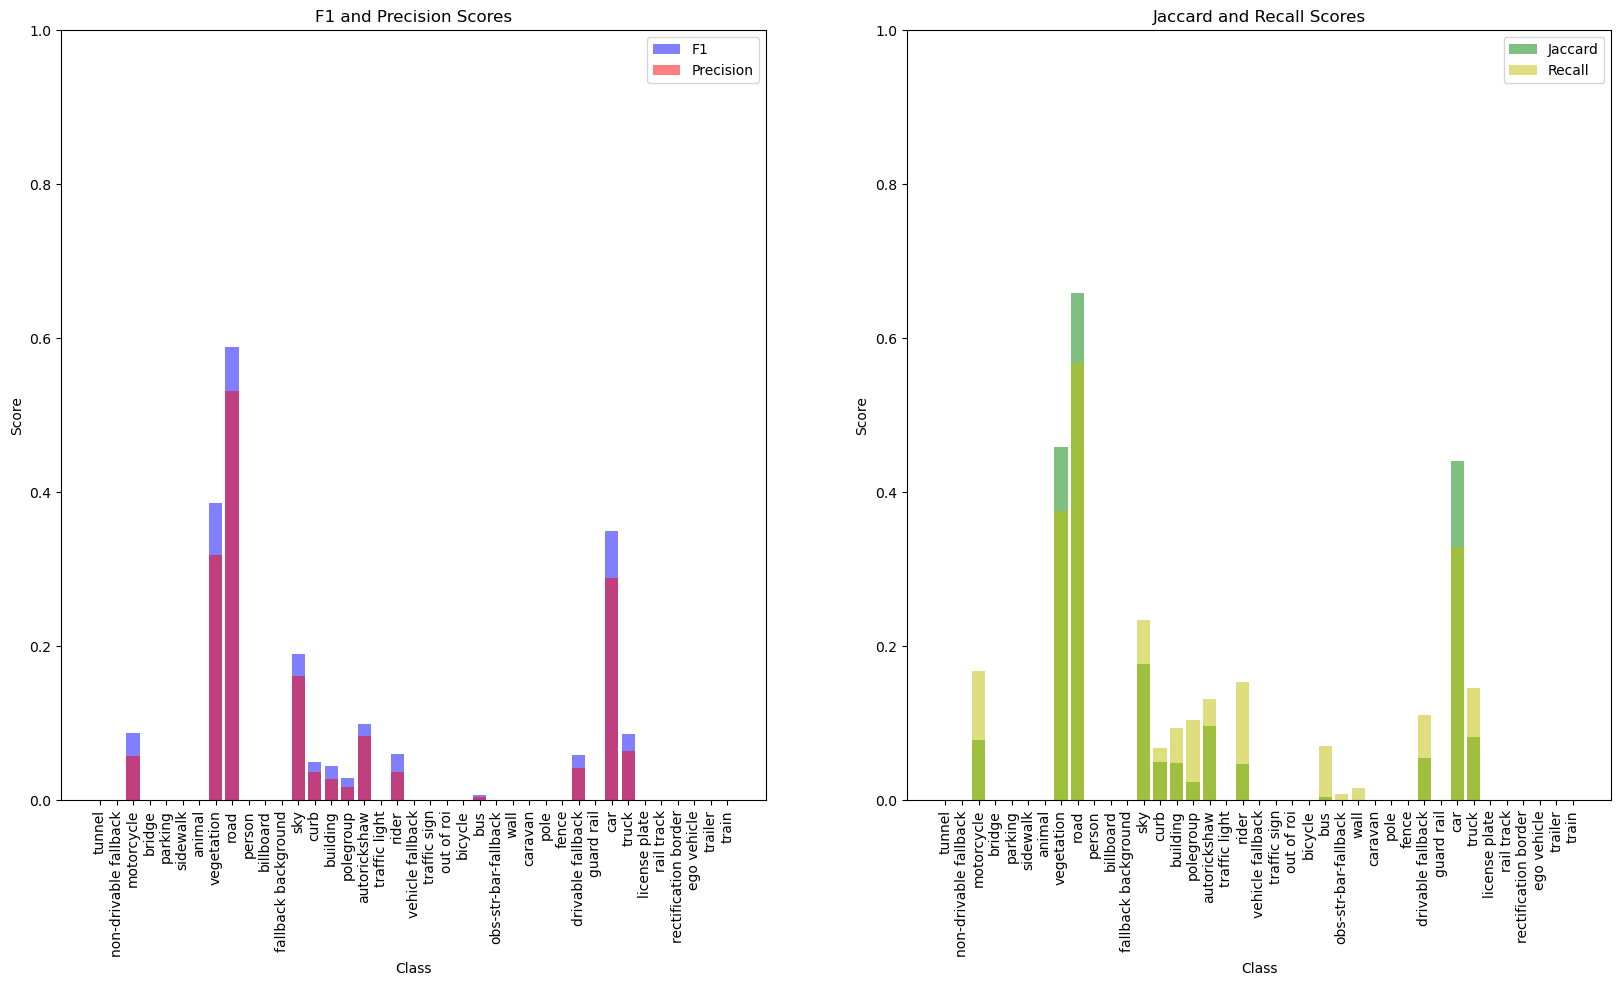

In [86]:
import matplotlib.pyplot as plt

# assuming `score` is a numpy array of shape (4, num_classes)
f1_scores = score[0]
precision_scores = score[1]
jaccard_scores = score[2]
recall_scores = score[3]
class_names = classes

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# subplot 1: F1 and precision scores
axs[0].bar(class_names, f1_scores, color='b', alpha=0.5, label='F1')
axs[0].bar(class_names, precision_scores, color='r', alpha=0.5, label='Precision')
axs[0].set_title('F1 and Precision Scores')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Score')
axs[0].set_ylim([0, 1])
axs[0].legend()
axs[0].tick_params(axis='x', rotation=90)

# subplot 2: Jaccard and recall scores
axs[1].bar(class_names, jaccard_scores, color='g', alpha=0.5, label='Jaccard')
axs[1].bar(class_names, recall_scores, color='y', alpha=0.5, label='Recall')
axs[1].set_title('Jaccard and Recall Scores')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Score')
axs[1].set_ylim([0, 1])
axs[1].legend()
axs[1].tick_params(axis='x', rotation=90)

plt.show()


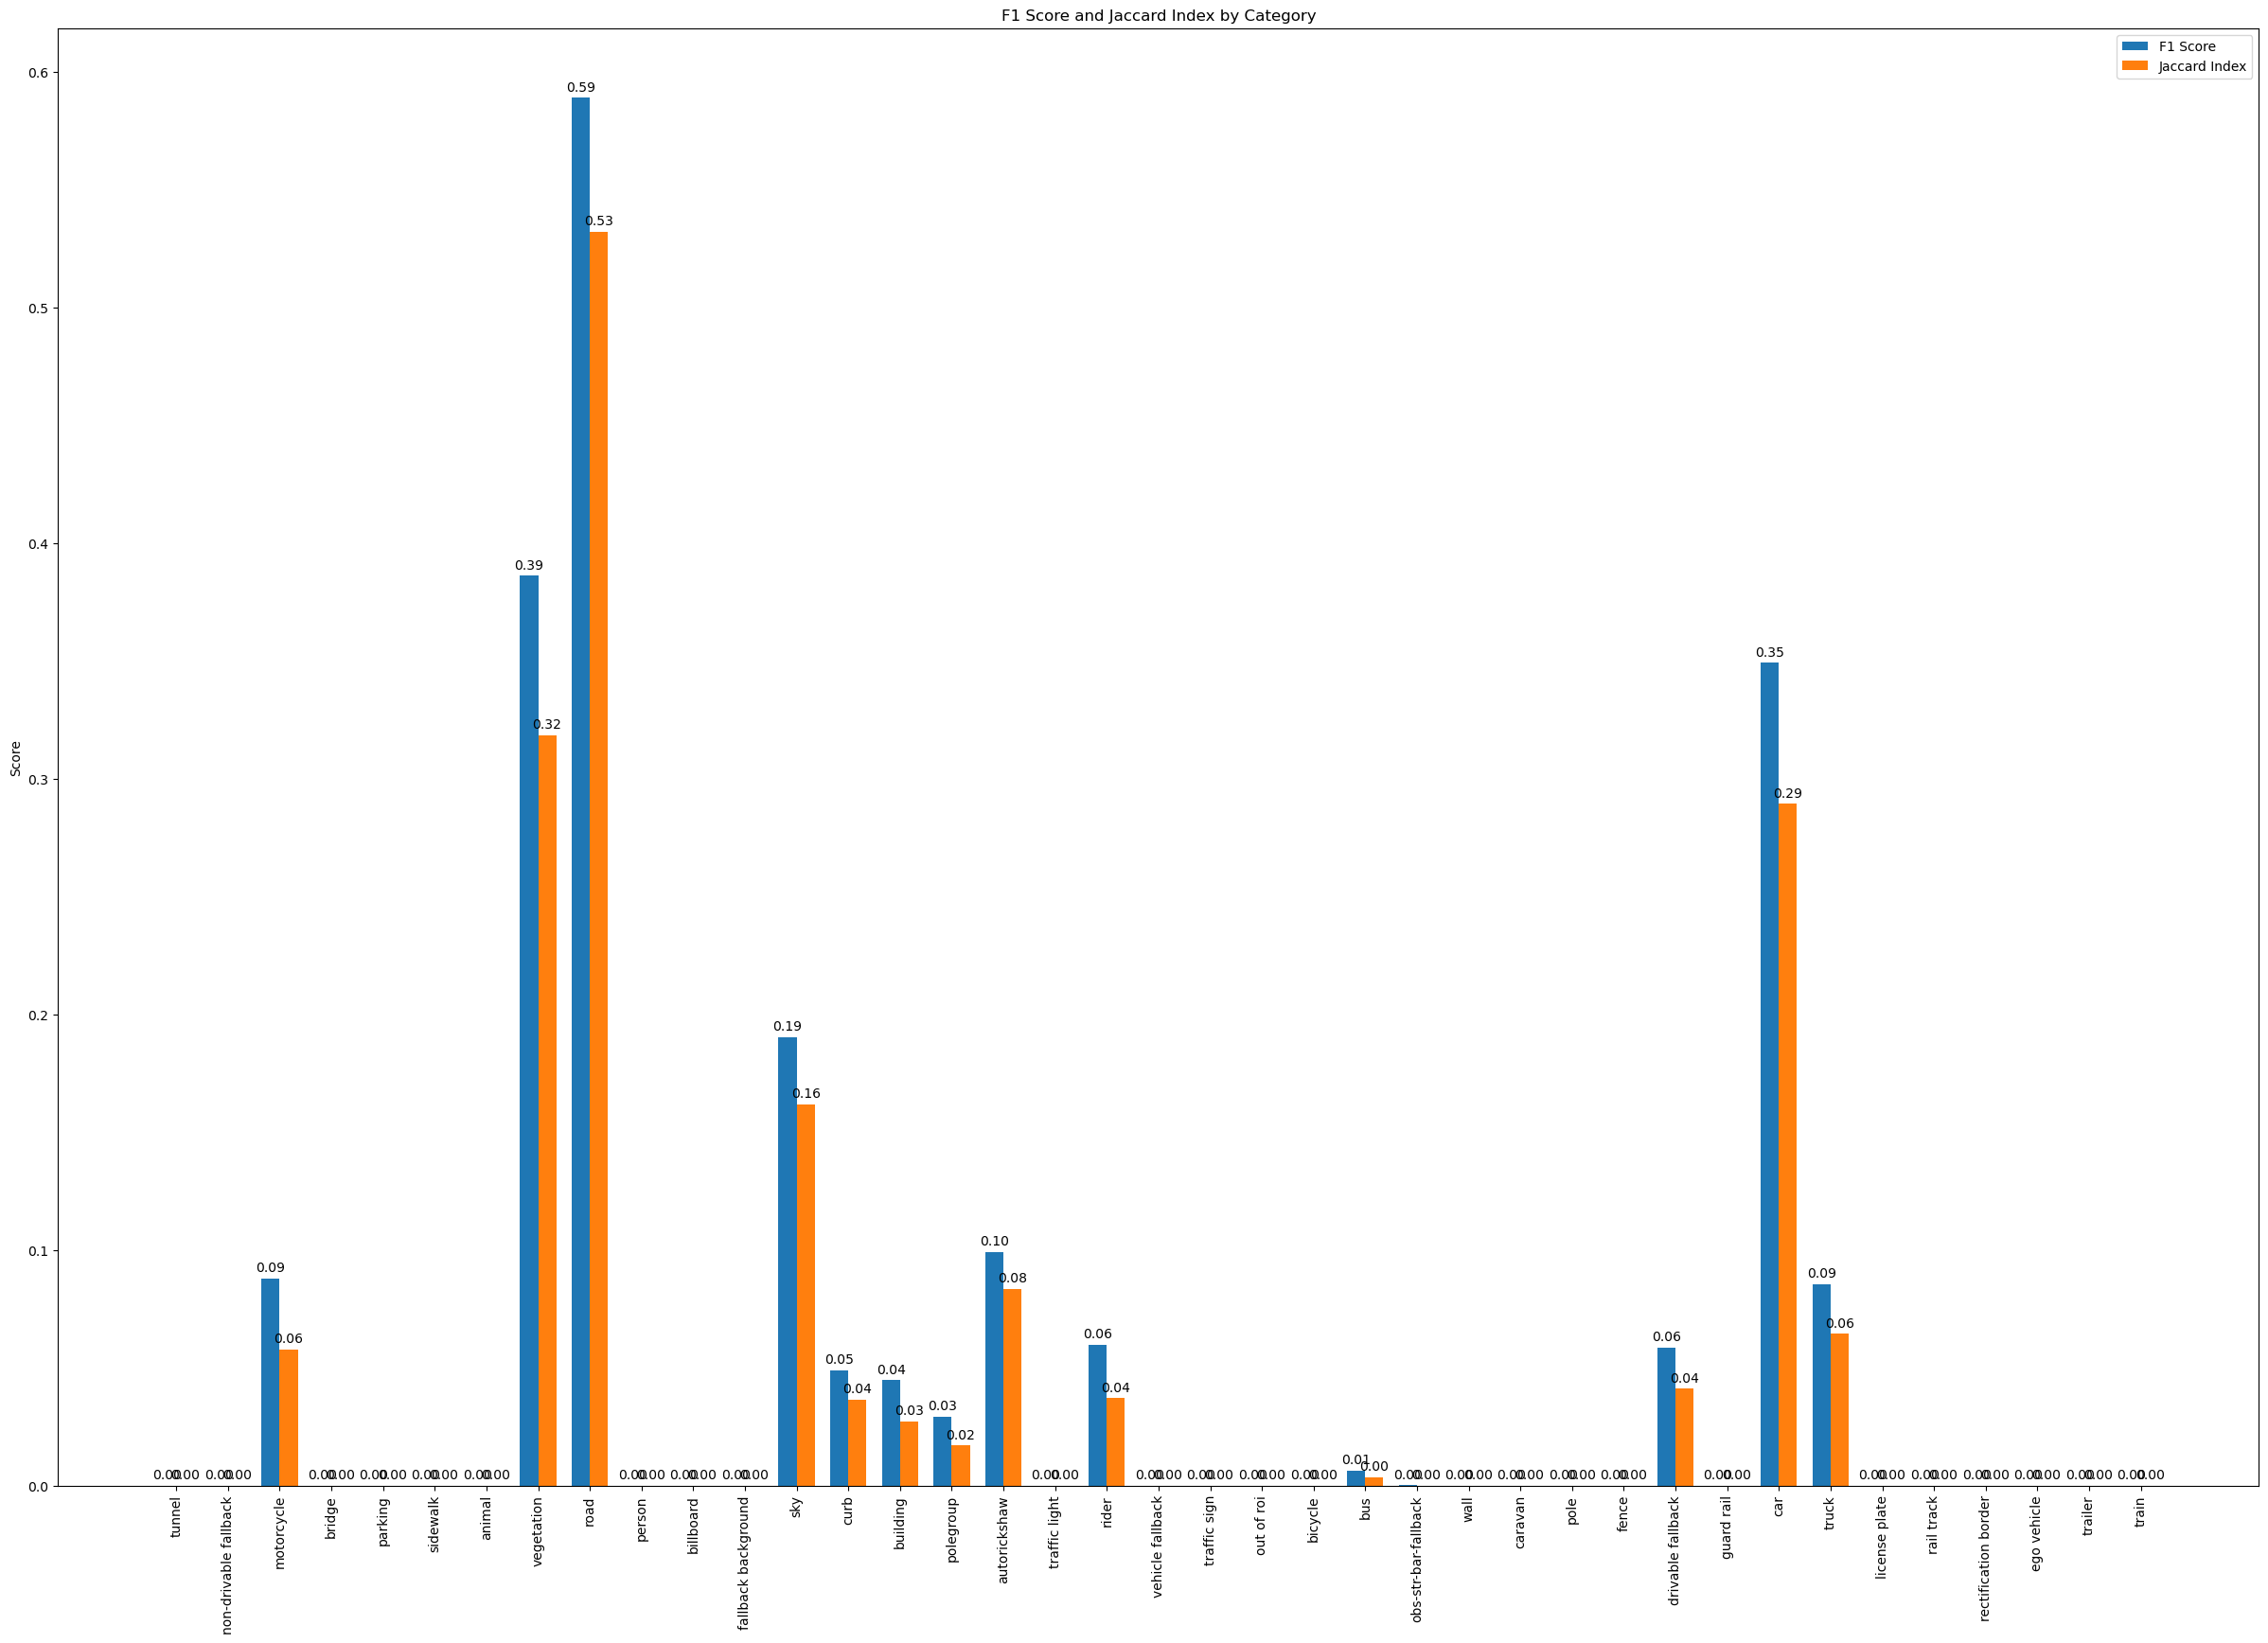

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

# Set up the plot
x = np.arange(len(class_names))
width = 0.35
fig, ax = plt.subplots(figsize=(30,20))
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
rects2 = ax.bar(x + width/2, jaccard_scores, width, label='Jaccard Index')


# Add labels and title
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(class_names,rotation = 90)
ax.legend()
plt.title('F1 Score and Jaccard Index by Category')

# Add values above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.show()


## Validating the Results

In [31]:
import numpy as np
from PIL import Image
import os
import csv

# Path to directory containing the predicted and ground truth images
dir_path = 'P:/Panoptic_Segmentation/'

# Get a list of the predicted and ground truth image file names
predicted_files = sorted(os.listdir("P:/Panoptic_Segmentation/Results_pred"))
ground_truth_files = sorted(os.listdir("P:/Panoptic_Segmentation/new_data/test/mask"))

# Initialize arrays to store the IoU and PA scores for each image
ious = np.zeros(len(predicted_files))
pas = np.zeros(len(predicted_files))

with open('Scores1_final.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'IoU', 'PA'])

    # Loop through each image and calculate the scores
    for i in range(len(predicted_files)):
        # Load the predicted and ground truth segmentation maps for the current image
        predicted = np.array(Image.open(os.path.join('P:/Panoptic_Segmentation/Results_pred', predicted_files[i])))
        ground_truth = np.array(Image.open(os.path.join("P:/Panoptic_Segmentation/new_data/test/mask", ground_truth_files[i])))

        # Convert the segmentation maps to binary format
        predicted_binary = np.where(predicted > 0, 1, 0)
        ground_truth_binary = np.where(ground_truth > 0, 1, 0)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(predicted_binary & ground_truth_binary)
        union = np.sum(predicted_binary) + np.sum(ground_truth_binary) - intersection

        # Calculate the IoU score
        iou = intersection / union
        # Calculate the PA score
        pa = np.sum(predicted_binary == ground_truth_binary) / predicted_binary.size

        writer.writerow([predicted_files[i], iou, pa])
        
        # Store the scores in the arrays for mean calculation
        ious[i] = iou
        pas[i] = pa

# Calculate the mean scores across all images
mean_iou = np.mean(ious)
mean_pa = np.mean(pas)

# Print the mean scores
print('Mean IoU score:', mean_iou)
print('Mean PA score:', mean_pa)


Mean IoU score: 0.855587983375148
Mean PA score: 0.8831298309779725


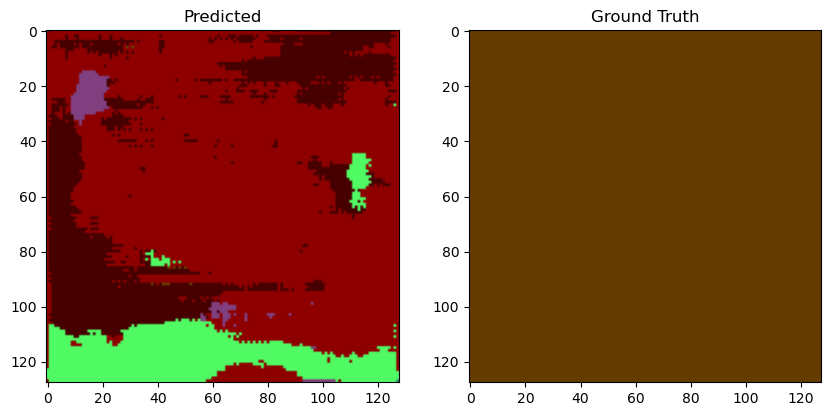

In [32]:
import matplotlib.pyplot as plt

# Set the index of the image you want to visualize
image_index = 0

# Load the predicted and ground truth segmentation maps for the selected image
predicted = np.array(Image.open(os.path.join('P:/Panoptic_Segmentation/Results_pred', predicted_files[image_index])))
ground_truth = np.array(Image.open(os.path.join("P:/Panoptic_Segmentation/new_data/test/mask", ground_truth_files[image_index])))

# Visualize the predicted and ground truth segmentation maps side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(predicted)
ax[0].set_title('Predicted')
ax[1].imshow(ground_truth)
ax[1].set_title('Ground Truth')
plt.show()

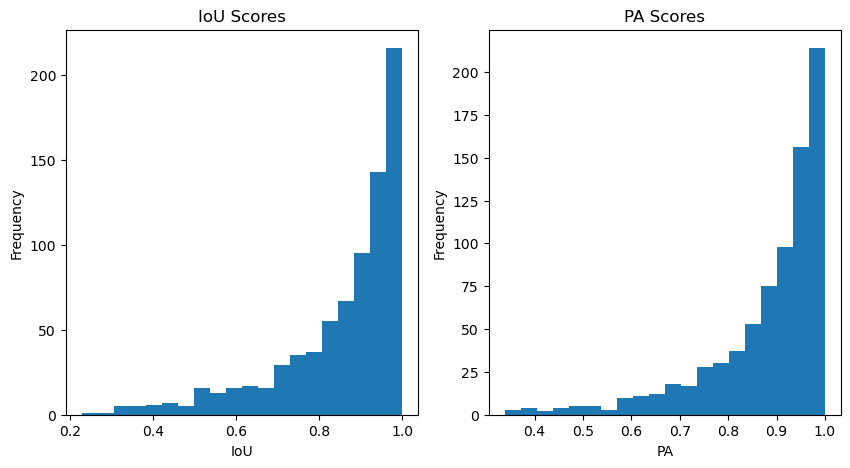

In [33]:
# Create histograms of the IoU and PA scores
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ious, bins=20)
ax[0].set_xlabel('IoU')
ax[0].set_ylabel('Frequency')
ax[0].set_title('IoU Scores')
ax[1].hist(pas, bins=20)
ax[1].set_xlabel('PA')
ax[1].set_ylabel('Frequency')
ax[1].set_title('PA Scores')
plt.show()


<Axes: >

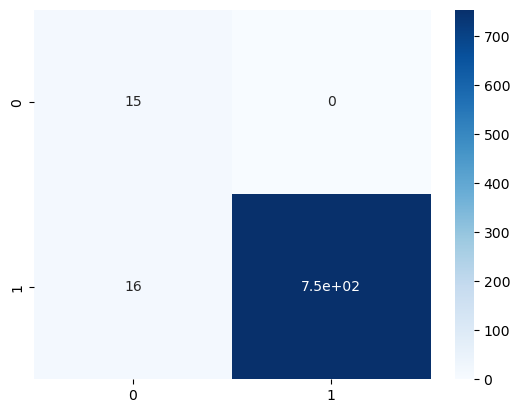

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted and ground truth labels
predicted_labels = np.where(ious > 0.5, 1, 0)
ground_truth_labels = np.where(pas > 0.5, 1, 0)

# Create the confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

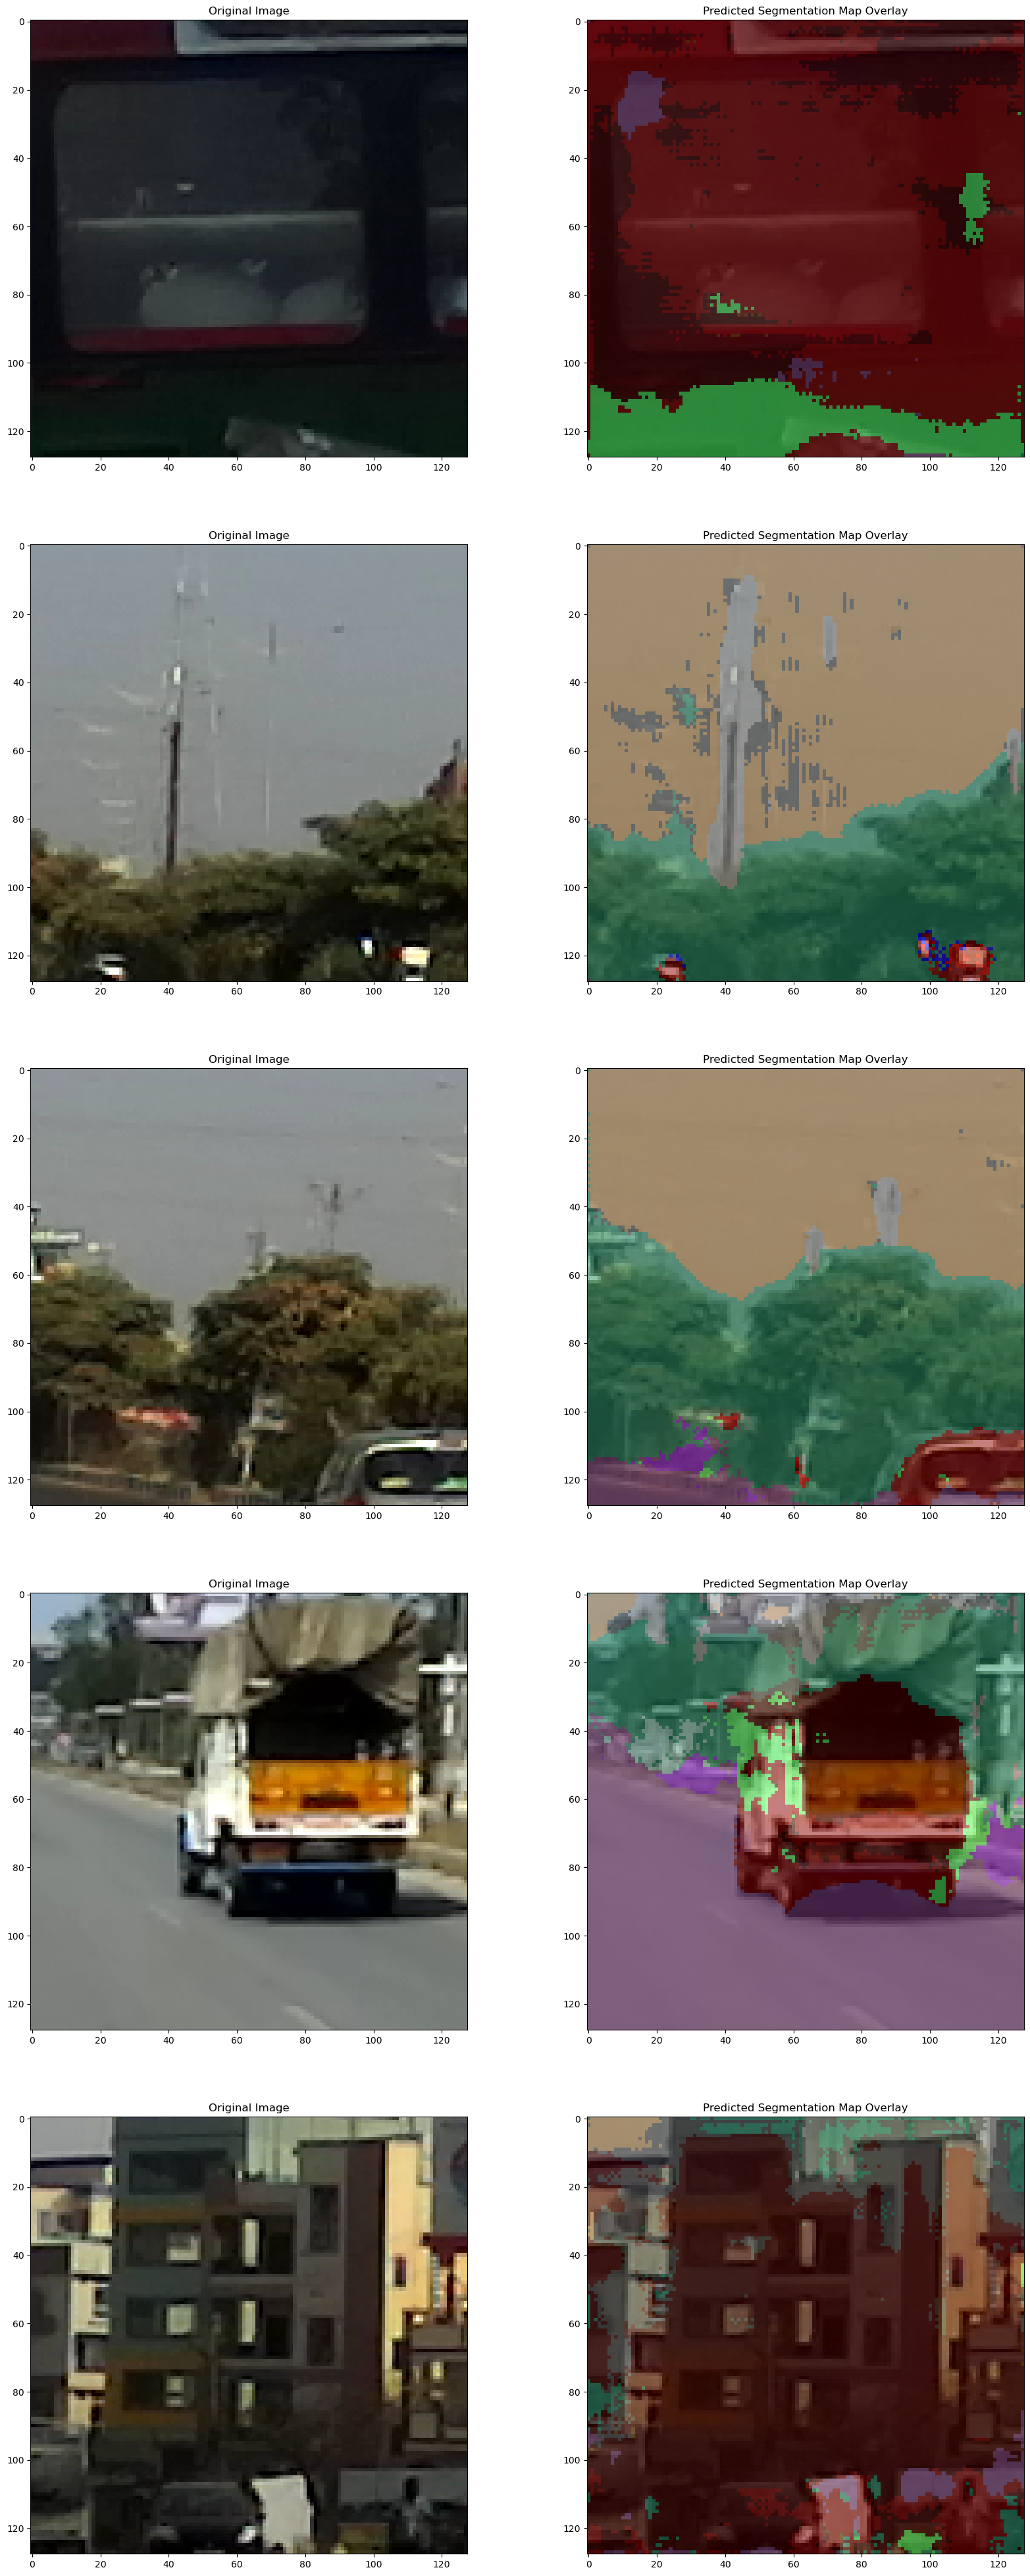

In [55]:
import matplotlib.pyplot as plt

# Path to directory containing the predicted and ground truth images
dir_path = 'P:/Panoptic_Segmentation/'

# Get a list of the predicted and ground truth image file names
predicted_files = sorted(os.listdir("P:/Panoptic_Segmentation/Results_pred"))
ground_truth_files = sorted(os.listdir("P:/Panoptic_Segmentation/new_data/test/mask"))
image_files = sorted(os.listdir("P:/Panoptic_Segmentation/new_data/test/image"))

# Loop through 5 random images and display them with the predicted segmentation map overlaid on top
fig, axs = plt.subplots(5, 2, figsize=(20, 50))
for i in range(5):
    # Load the original image
    image = Image.open(os.path.join("P:/Panoptic_Segmentation/new_data/test/image", image_files[i]))

    # Load the predicted and ground truth segmentation maps for the current image
    predicted = Image.open(os.path.join('P:/Panoptic_Segmentation/Results_pred', predicted_files[i]))
    ground_truth = Image.open(os.path.join("P:/Panoptic_Segmentation/new_data/test/mask", ground_truth_files[i]))

    # Create a new image with the predicted segmentation map overlaid on top
    overlay = Image.blend(image, predicted.convert('RGB'), alpha=0.5)

    # Display the original image and the overlay side by side
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(overlay)
    axs[i, 1].set_title('Predicted Segmentation Map Overlay')
plt.show()

Text(0.5, 1.0, 'Precision-Recall Curve')

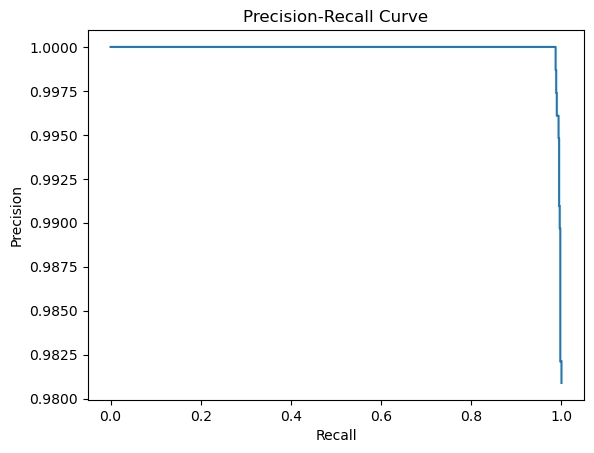

In [36]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate the precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(ground_truth_labels, ious)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

Text(0.5, 1.0, 'ROC Curve')

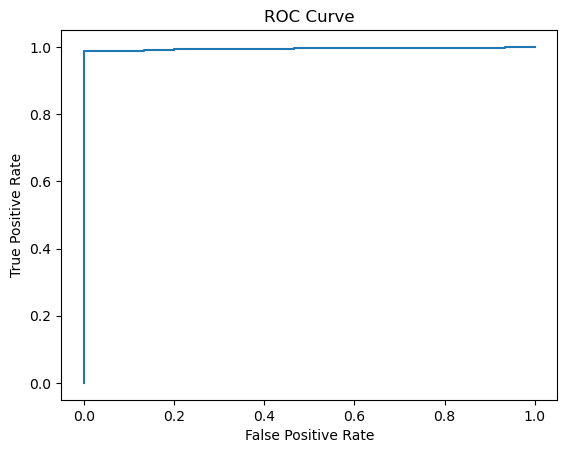

In [37]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the true positive rate and false positive rate for different threshold values
fpr, tpr, thresholds = roc_curve(ground_truth_labels, ious)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

<Axes: >

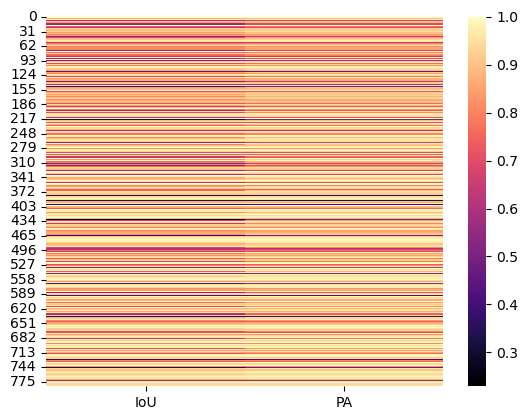

In [64]:
import seaborn as sns

# Create a DataFrame with the IoU and PA scores for each image
scores_df = pd.DataFrame({'IoU': ious, 'PA': pas})

# Create a heatmap to visualize the distribution of scores
sns.heatmap(scores_df, cmap='magma')


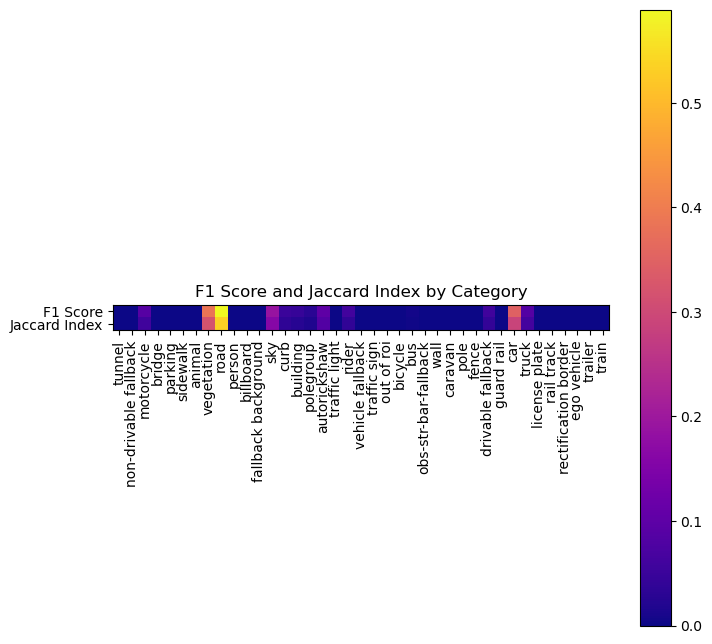

In [111]:
import matplotlib.pyplot as plt

# assuming `score` is a numpy array of shape (2, num_classes)
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

plt.figure(figsize=(8,8))
plt.imshow([f1_scores, jaccard_scores], cmap='plasma')
plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(2), ['F1 Score', 'Jaccard Index'])
plt.xticks(range(len(class_names)), class_names, rotation = 90)
plt.colorbar()
plt.title('F1 Score and Jaccard Index by Category')
plt.show()


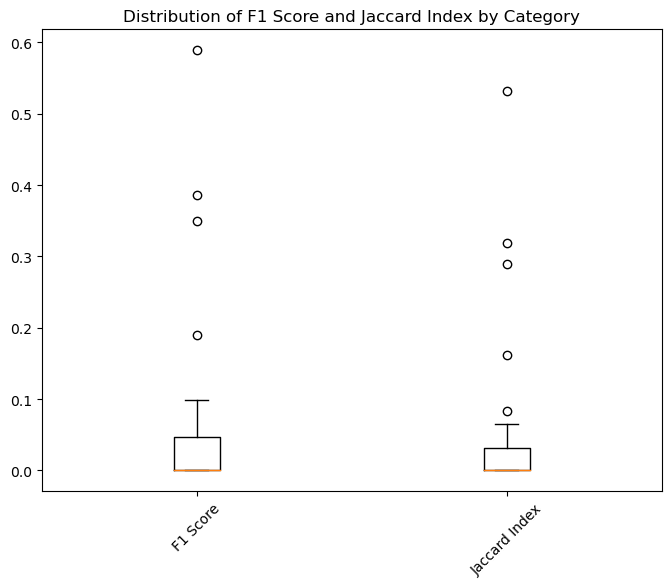

In [102]:
import matplotlib.pyplot as plt

# assuming `score` is a numpy array of shape (2, num_classes)
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

plt.figure(figsize=(8,6))
plt.boxplot([f1_scores, jaccard_scores], labels=['F1 Score', 'Jaccard Index'])
plt.xticks(rotation=45)
plt.title('Distribution of F1 Score and Jaccard Index by Category')
plt.show()


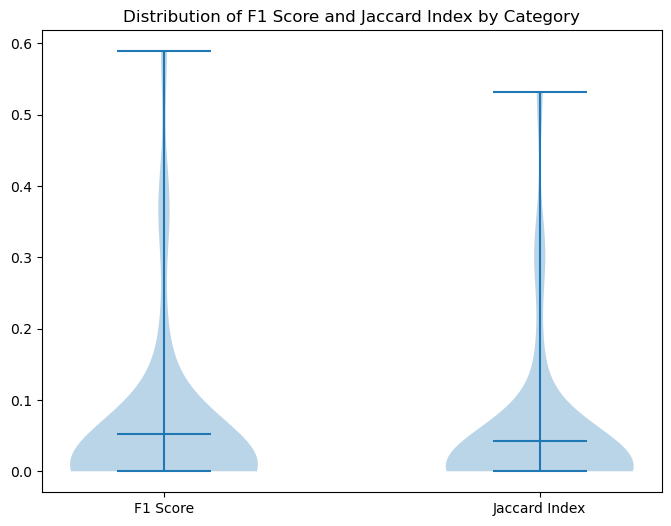

In [103]:
import matplotlib.pyplot as plt

# assuming `score` is a numpy array of shape (2, num_classes)
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

plt.figure(figsize=(8,6))
plt.violinplot([f1_scores, jaccard_scores], showmeans=True)
plt.xticks([1, 2], ['F1 Score', 'Jaccard Index'])
plt.title('Distribution of F1 Score and Jaccard Index by Category')

plt.show()


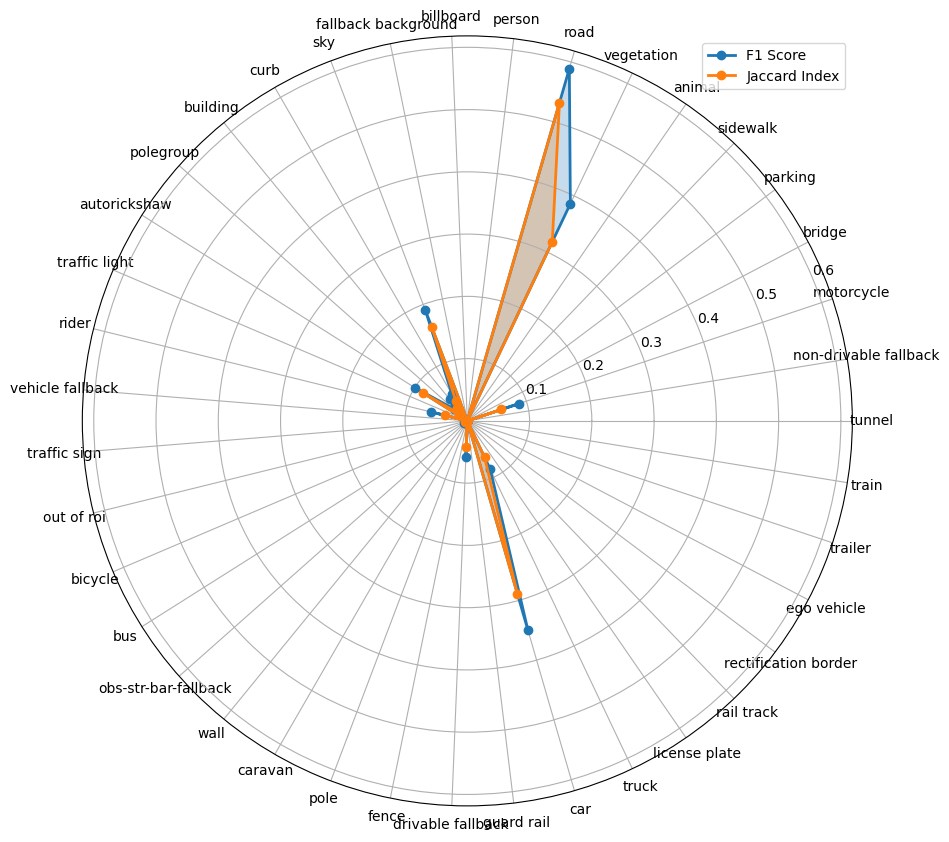

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# assuming `score` is a numpy array of shape (2, num_classes)
f1_scores = score[0]
jaccard_scores = score[1]
class_names = classes

# set up angles for radar chart
angles = np.linspace(0, 2*np.pi, len(class_names), endpoint=False)

# close the plot
f1_scores = np.concatenate((f1_scores, [f1_scores[0]]))
jaccard_scores = np.concatenate((jaccard_scores, [jaccard_scores[0]]))
angles = np.concatenate((angles, [angles[0]]))

# create radar chart
plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
ax.plot(angles, f1_scores, 'o-', linewidth=2, label='F1 Score')
ax.fill(angles, f1_scores, alpha=0.25)
ax.plot(angles, jaccard_scores, 'o-', linewidth=2, label='Jaccard Index')
ax.fill(angles, jaccard_scores, alpha=0.25)
ax.set_thetagrids(angles[:-1] * 180/np.pi, class_names)
ax.legend(loc='upper right')

plt.show()




In [2]:
import tensorflow as tf 
print(tf.__version__)

2.12.0


In [3]:
import keras 
print(keras.__version__)

2.12.0


In [4]:
import cv2
print(cv2.__version__)

4.7.0


In [5]:
import numpy 
print(numpy.__version__)

1.23.5


In [6]:
import PIL
print(PIL.__version__)

9.4.0


In [7]:
import scipy

print(scipy.__version__)


1.10.0


In [8]:
import matplotlib
print(matplotlib.__version__)

3.7.0


In [9]:
import skimage

print(skimage.__version__)


0.19.3


In [10]:
import h5py
print(h5py.__version__)

3.7.0


In [12]:
import tqdm
import glob
import seaborn

print(tqdm.__version__,seaborn.__version__)

4.64.1 0.12.2
